In [13]:
# functionality
import numpy as np
import pandas as pd


# plotting and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# ggplot utilities
from plotnine import (ggplot, geom_line, xlab, ylab, ggtitle, aes, theme, xlim, ylim,
                     geom_density, geom_histogram, after_stat, geom_ribbon, geom_smooth,
                      facet_wrap,  geom_point, scale_color_manual, scale_alpha_manual)

# interactive visualizations
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from itables import show

# helper tools
from visualization import plot_currency_series
from forex_python.converter import CurrencyRates

# setting some options for visualization
converter = CurrencyRates()
pd.options.display.float_format = '{:,.2f}'.format

plt.style.use('Solarize_Light2')

### Loading the data

In [7]:
data = pd.read_excel("../data/raw/cash_data.xlsx")

# transform the column names to a more computer format
data.columns = [x.replace(" ", "_") for x in data.columns.str.lower()]

# transform the dates to a correct format
data = data.assign(
    date=pd.to_datetime(data.date),
    cash_outflow=-data["cash_outflow"]
)

show(data)

One of the problems we can see with this dataset is that don't have a reference currency for the period of the inflow\outflow. That prevents us from comparing the different currency accounts in volume.

Nonetheless, we can still compare the currency accounts in a matter of frequency of inflow.

In [8]:
(data
 .assign(
    no_inflow_proportion=lambda df: df["cash_inflow"] == 0,
    no_outflow_proportion=lambda df: df["cash_outflow"] == 0,
)
 .groupby("currency")
 .mean()
 .reset_index()
 .rename(
    columns={
        "cash_inflow": "cash_inflow_mean",
        "cash_outflow": "cash_outflow_mean",
    }
)
 .pipe(show)
)

C:\Users\Nikola_Shahpazov\AppData\Local\Temp\ipykernel_16324\2049157441.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


We can see that the most active accounts are `GBP`, `JPY`, `BRL`, while the most inactive are `IDR`, `VND`, `KRW`.
One assumption we can make about that is that the company is working most frequently with UK clients\partners.

We can also compare the investigate the different currencies visually.

In [9]:
plot_currency = lambda currency, flow: plot_currency_series(data, flow, currency)
interact(plot_currency, currency=data["currency"].unique(), flow=["cash_inflow", "cash_outflow"])

interactive(children=(Dropdown(description='currency', options=('CNY', 'TRY', 'RUB', 'IDR', 'MXN', 'USD', 'KRW…

<function __main__.<lambda>(currency, flow)>

c:\Users\Nikola_Shahpazov\AppData\Local\miniconda3\envs\py39\lib\site-packages\plotnine\facets\facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


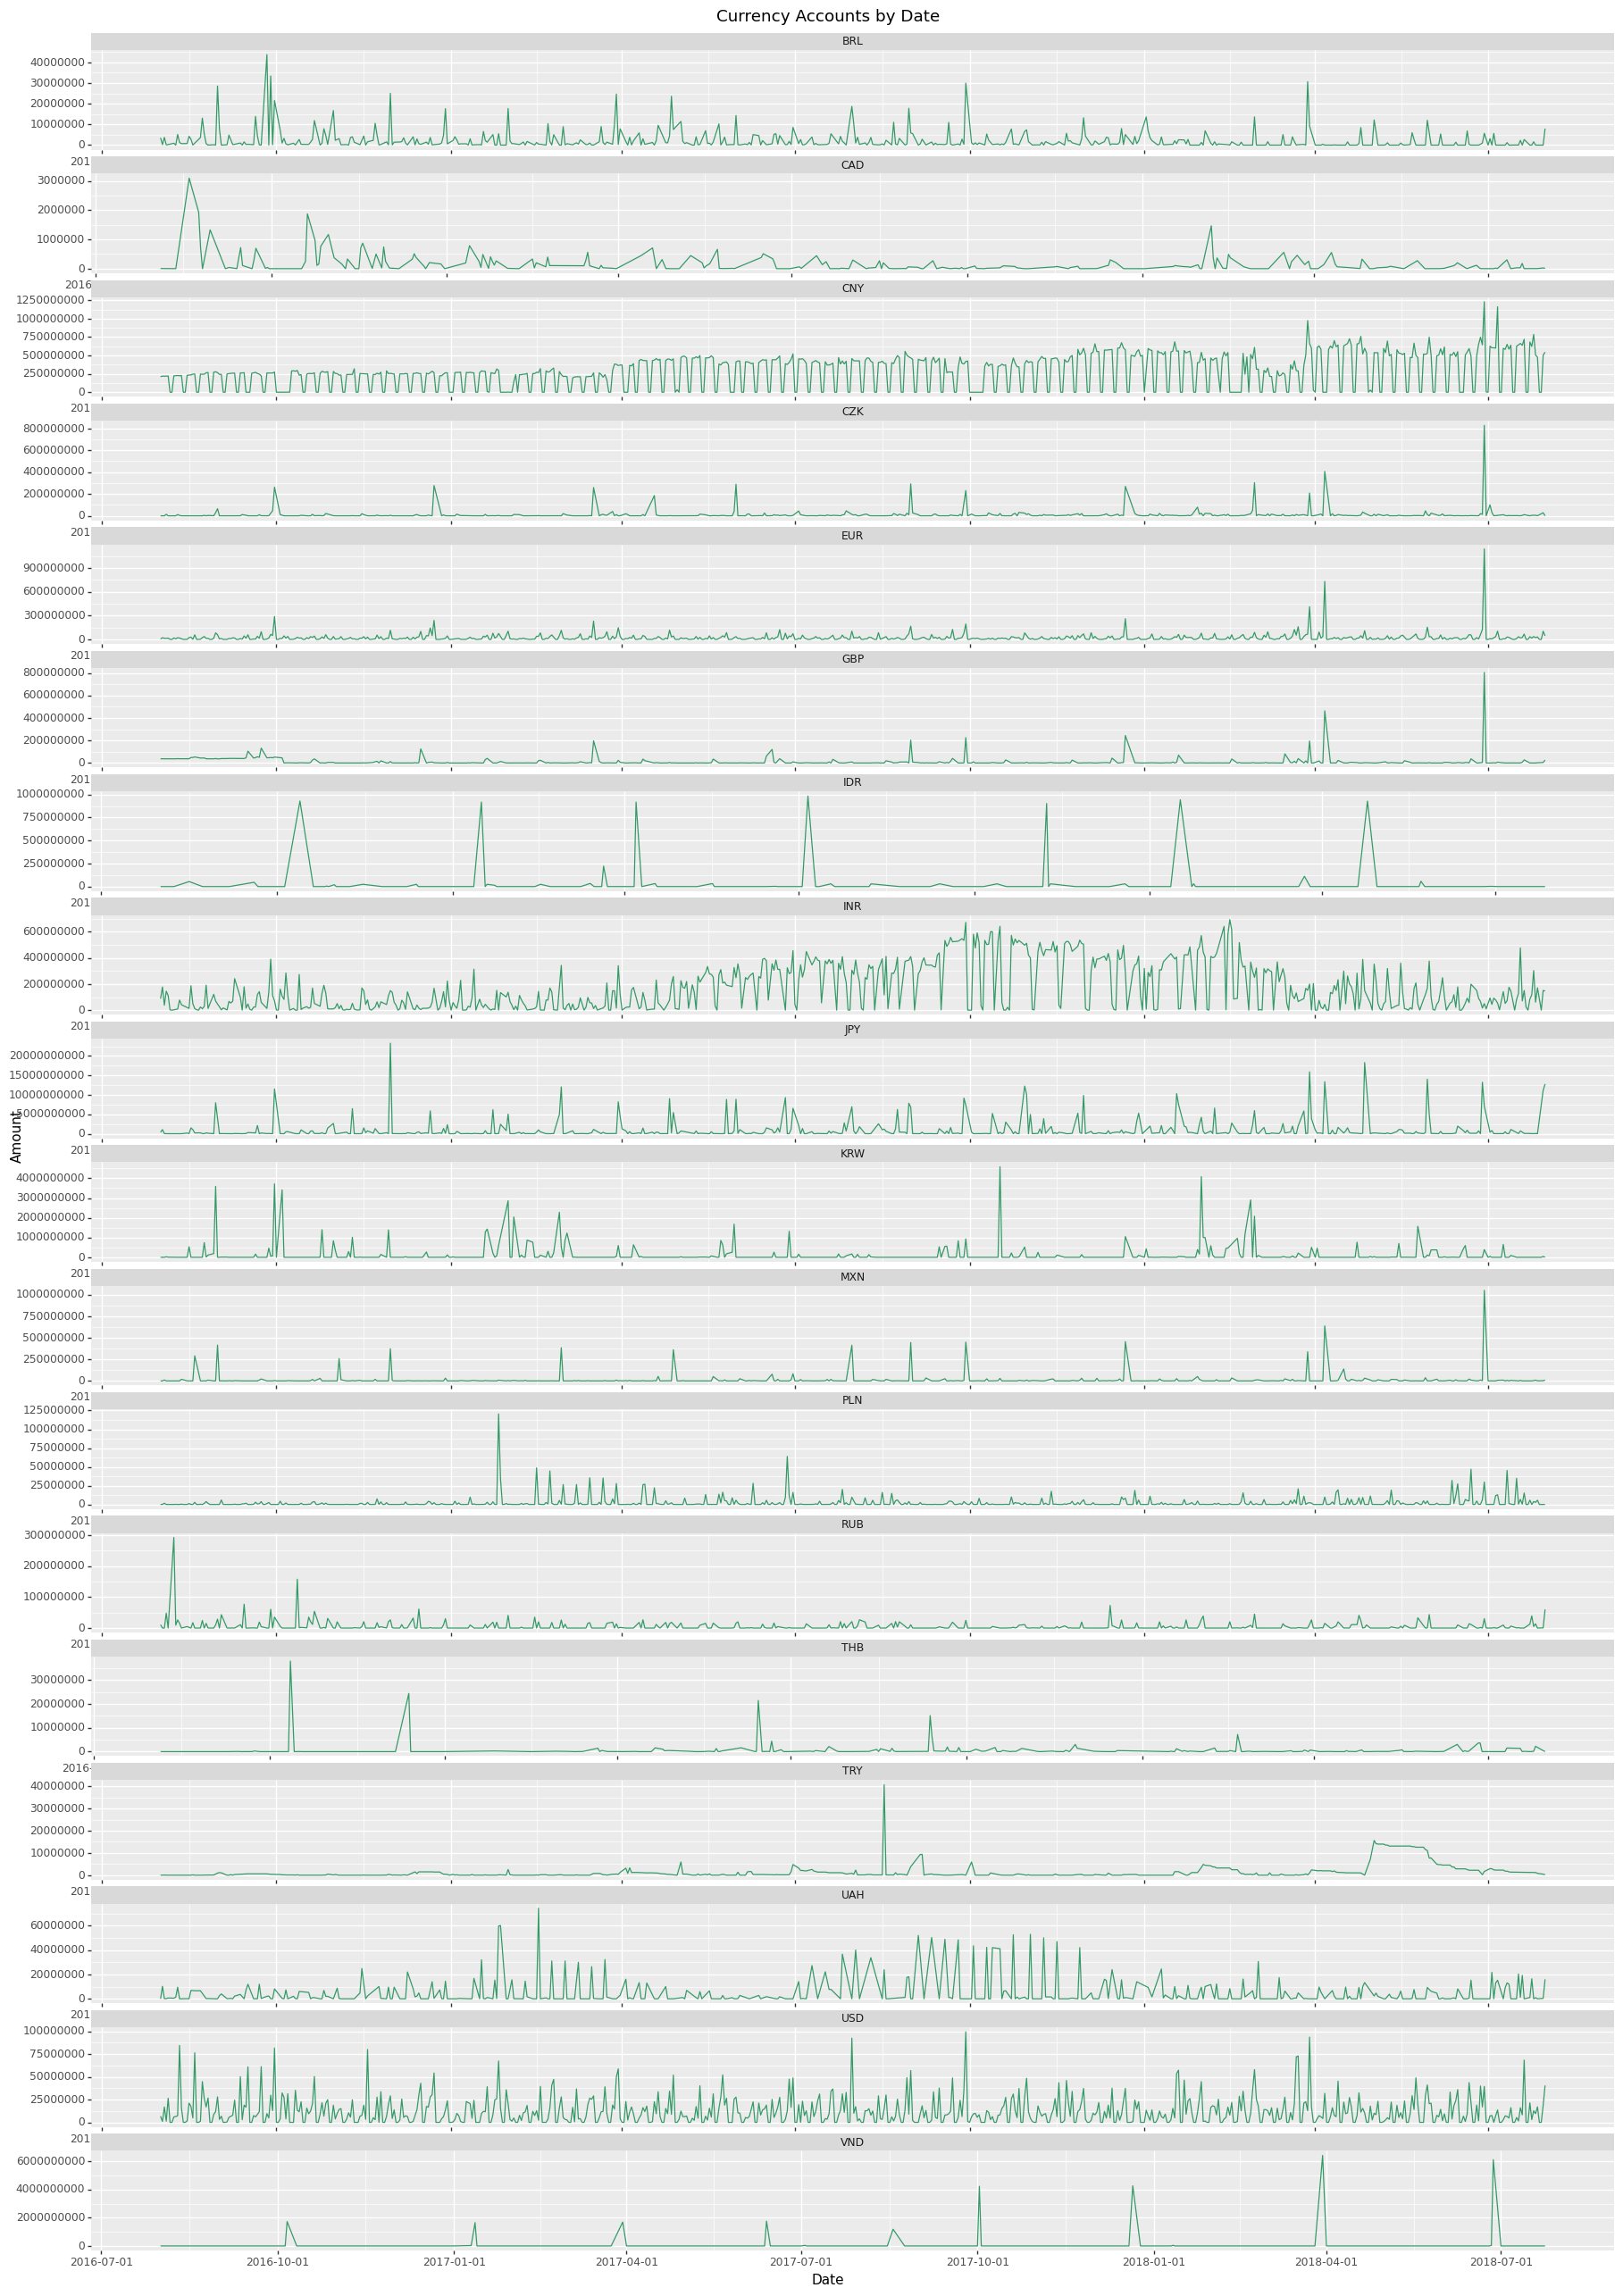

<ggplot: (187458292312)>

In [10]:
(ggplot(data) +
    aes(x="date", y="cash_inflow") +
    geom_line(color="#339966") +
    theme(figure_size=(22, 32)) +
    facet_wrap("currency", scales="free", ncol=1) +
    ggtitle("Currency Accounts by Date") +
    xlab("Date") +
    ylab("Amount")
)

### Convert to a common reference

In order to compare the different currencies, we have convert them to a common functional currency, respecting the dates and the values of the currencies at those particular dates.

In [18]:
# convert to a functional currency
converted_df = data[((data.currency != "UAH") & (data.currency != "VND"))]
converted = converted_df.apply(
    lambda x: converter.convert(x["currency"], "USD", x["cash_inflow"]),
    axis=1,
)
converted_df = converted_df.assign(converted_in_usd=converted)

In [19]:
(converted_df
 .groupby("currency")
 .mean()
 ["converted_in_usd"]
 .reset_index()
 .rename(columns={"converted_in_usd": "converted_in_usd_mean"})
 .pipe(show)
)

C:\Users\Nikola_Shahpazov\AppData\Local\Temp\ipykernel_16324\1013286829.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


c:\Users\Nikola_Shahpazov\AppData\Local\miniconda3\envs\py39\lib\site-packages\plotnine\facets\facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


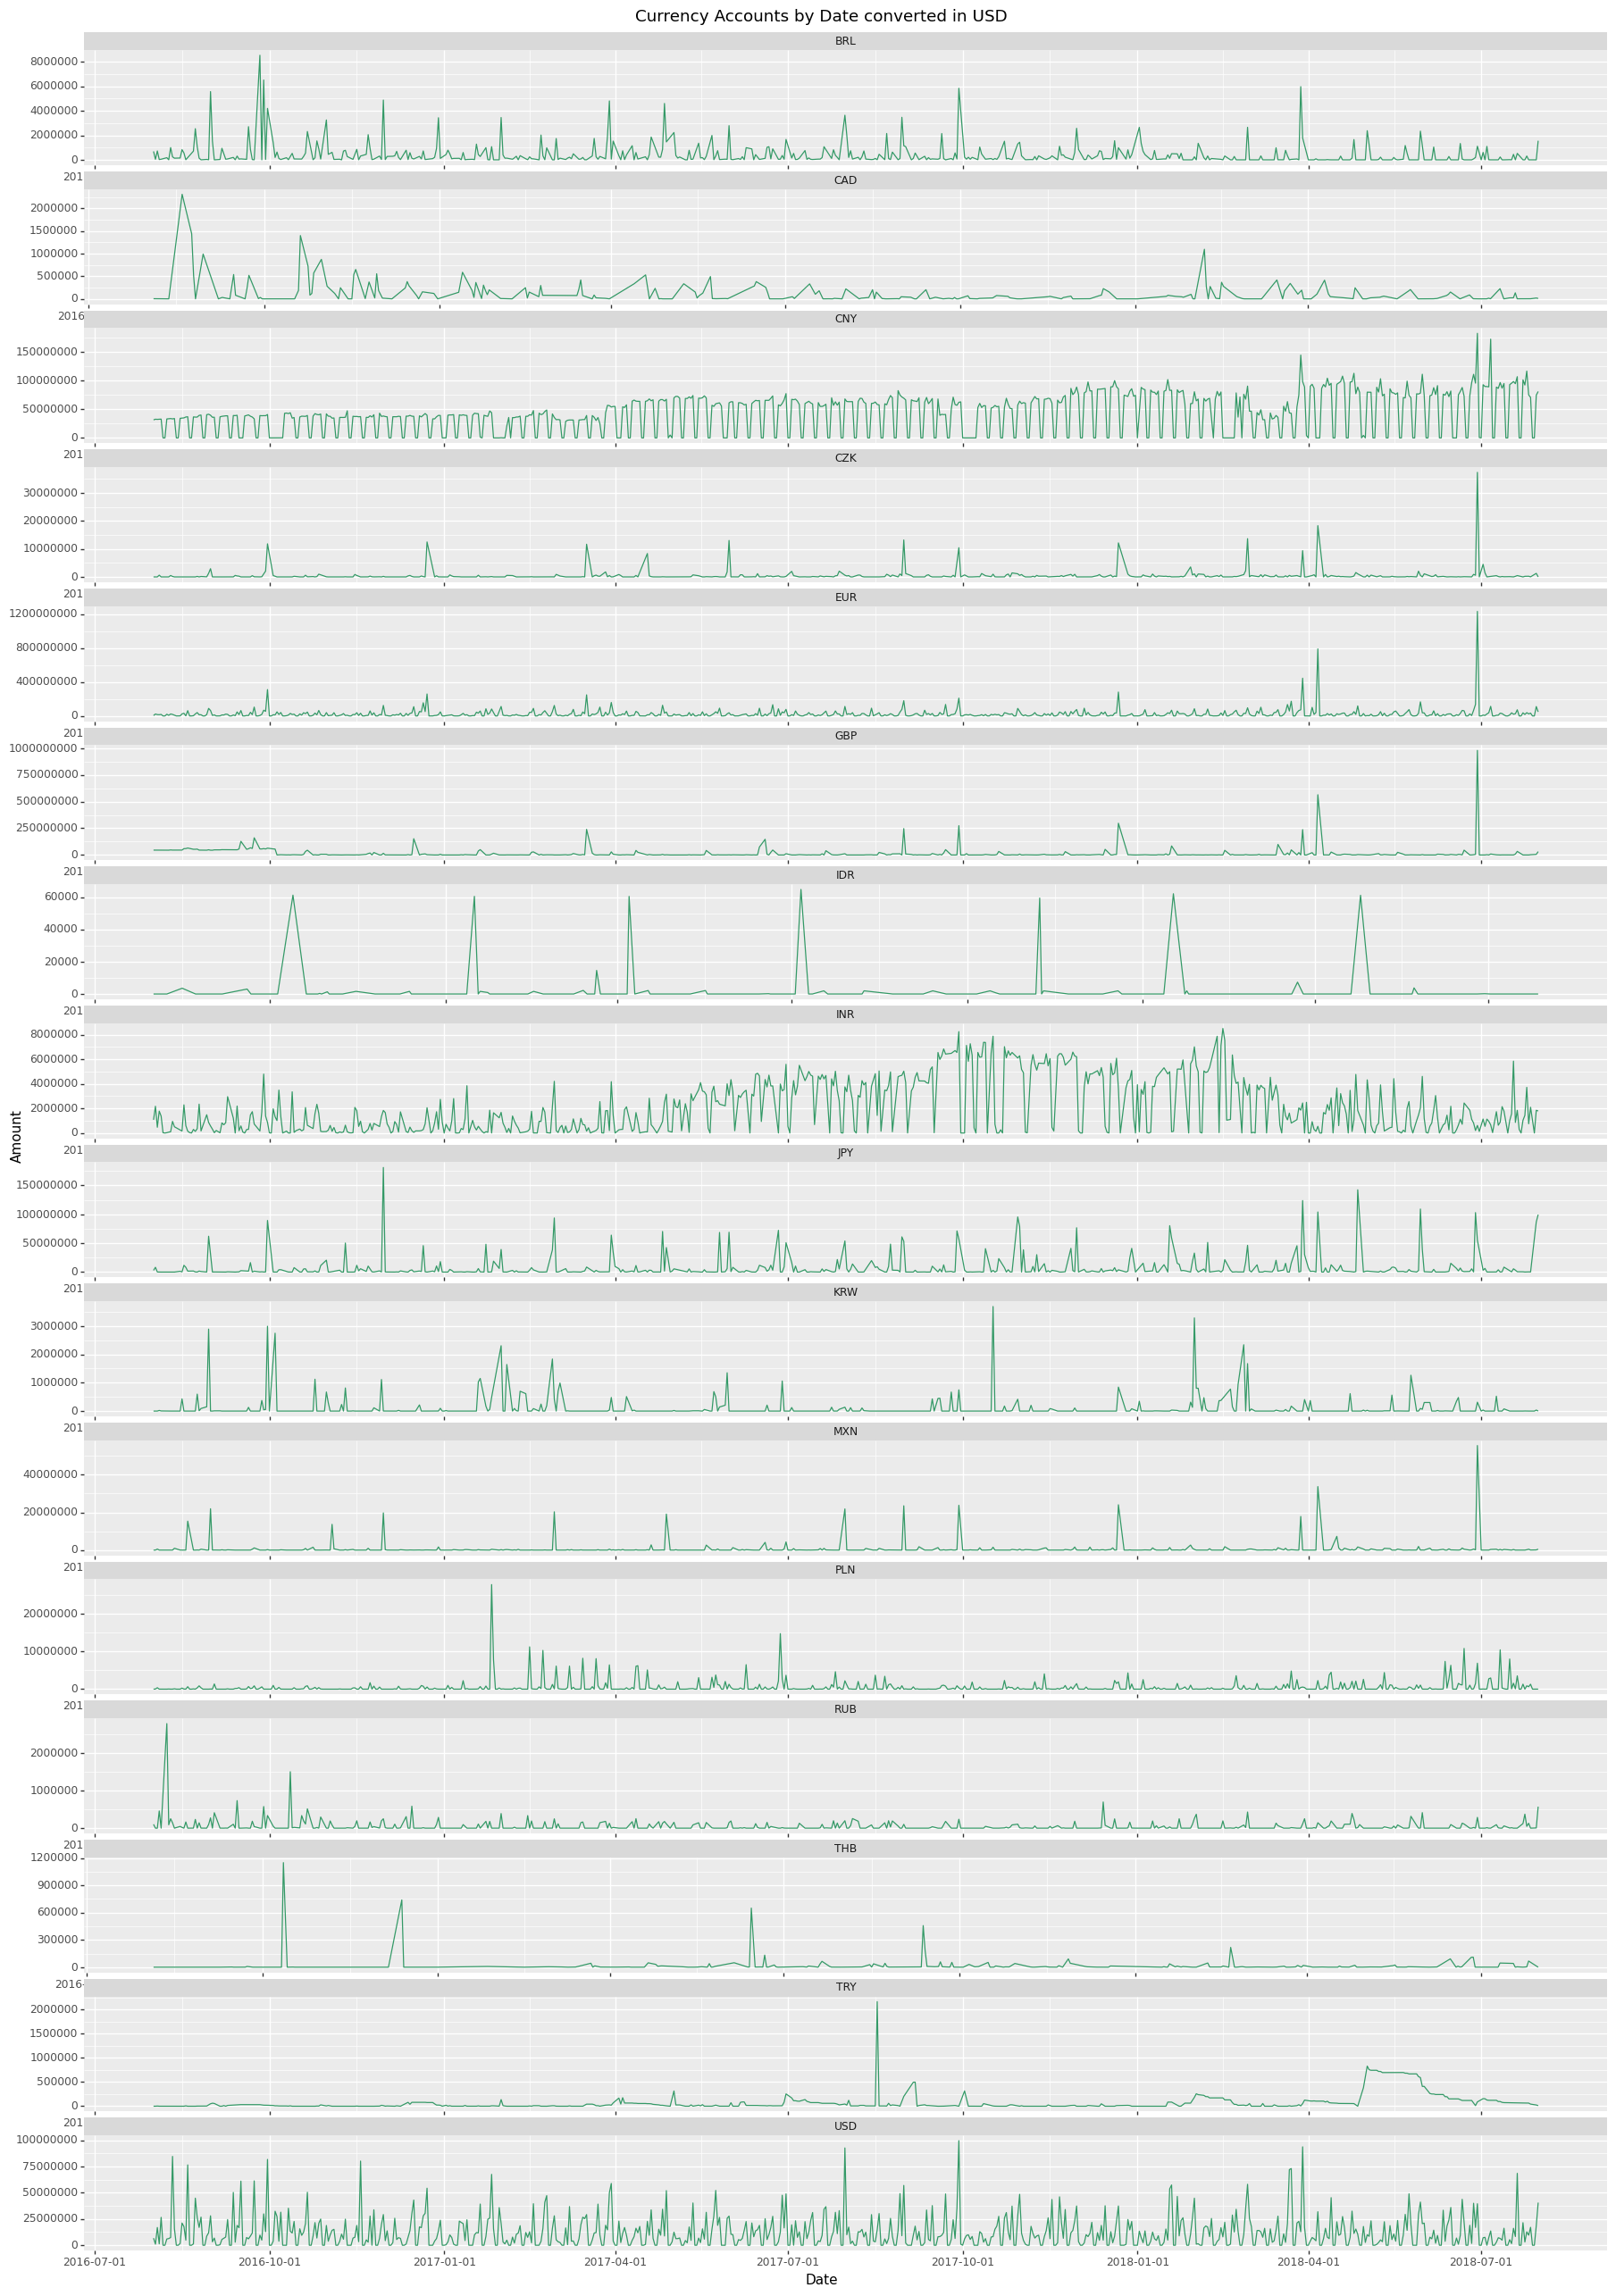

<ggplot: (187464826161)>

In [21]:
(ggplot(converted_df) +
    aes(x="date", y="converted_in_usd") +
    geom_line(color="#339966") +
    theme(figure_size=(22, 32)) +
    facet_wrap("currency", scales="free", ncol=1) +
    ggtitle("Currency Accounts by Date converted in USD") +
    xlab("Date") +
    ylab("Amount")
)

Some of the series look very similiar to each other, e.g. `CZK`, `EUR`, `GBP` and `MXN`.

Looking through the data, USD Cash inflow would be a good start for producing predictions. It's one of the top 5 when it comes to volume, it's also relatively oscilating and interesting to try producing predictions for it.